In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats 
import scipy.special
from scipy.special import comb
from scipy.optimize import minimize_scalar

import scipy
import math
import time
from sklearn.gaussian_process.kernels import RBF

from itertools import product
import random, time


# Class T0_est
Note that the implementation of this class involves the definition of T0 as an array of g points with entries {0,1} so that at index j-th corresponds 1 if T[j] belongs to T0, j in 1:g.

### Arguments:
- **x**  n*g covariates matrix
- **y**  n*1 response vector
- **K** kernel
- **sigma** 
- **alpha** value for approximation of p(T0)
- **T** discrete grid of g time instants
- **n_sim** number of simukations
- **burn** burn-in value
 
    
### Methods:
#### Instance methods:
- **get_T0()** getter of T0
- **get_k()** getter of k
- **chain_builder()** builds a list of all T0_i ∀ i-th iteration, i in 1:n_sim
- **next_T0(current)** takes the current element of the chain and chooses the next one according to the acceptance rate
- **candidate(current)** generates a feasible candidate for next element of the chain
- **acceptance_rate(current,new)** evaluates the rate given previous element and next candidate element of the chain
- **expected_k()** evaluates the expected number of runs (prior belief) of T to build T0_init
- **PT0(current)** evaluates the prior density p(T0)
- **generate_initialization()** generates all possible combinations of {0,1}^g with k runs (used to build T0_init)

#### Class methods:
- **idx_ends(current)** takes an array of times T0_j and returns a list of tuples (start index, end index) for each interval of T0_i (i in 1:n_sim)
- **idx_internal(idx_ends)** takes ends' indexes of an array of times T0_j and returns a list of tuples (first internal index, second internal index,..) of indexes   of internal points, one tuple for each interval of T0_i  (i in 1:n_sim)
- **idx_intervals(idx_ends)** takes ends' indexes of an array of times T0_j and returns a list of tuples (start index, first internal index, ...,end index) of indexes of all points, one tuple for each interval of T0_i  (i in 1:n_sim)
- **count_runs(current)** takes an array of times T0_j and returns the total number of runs

In [2]:
#def pseudo_rand(T0s):     
#    flag = False
#    T0 = np.array(random.choice(T0s))
#    while(flag == False):
#        lkl = likelihood(T0)
#        if math.isnan(lkl):
#            T0_init = list([int(np.random.choice([0,1])) for i in range(len(T))])
#        else:
#            flag = True

In [25]:
class T0_est:  
    def __init__(self, T, x, y,K,sigma,alpha,n_sim=10000,burn=0):
        self.T= T
        self.x=x
        self.y=y
        self.K=K
        self.sigma=sigma
        self.alpha=alpha
        self.n_sim=n_sim
        self.burn=burn
        self.n = y.shape[0]
        self.g = T.shape[0]
        self.exp_k=self.expected_k()
        
        flag = False
        while(flag == False):
            T0_init = self.generate_initialization()
            
            try:
                lkl = posterior(self.T,T0_init,self.x,self.y,self.K,self.sigma).likelihood()
                m = posterior(self.T,T0_init,self.x,self.y,self.K,self.sigma).M()
                if (math.isnan(lkl)) or (np.linalg.det(m)<=0):
                    T0_init = self.generate_initialization()
                else:
                    flag = True
            except: 
                continue
        
        self.T0_init = T0_init
        
        
    def generate_initialization(self):
        k = round(self.exp_k)
        T0 = np.zeros(g)
        k1 = np.random.randint(2,k)
        idxs = np.sort(np.random.randint(0,g,k1))
        sizes = np.random.randint(3,int(g/k),len(idxs))

        for i in range(len(idxs)):
            maxi = idxs[i]+sizes[i]
            T0[idxs[i]:min(g,maxi)]=np.ones(min(g,maxi)-idxs[i],dtype=int)

        print(list(T0))
        return list(T0)
    
    def get_T0(self):
        return self.T0_init
        
    def get_k(self):
        return self.exp_k
        
    def chain_builder(self):
        chain = [self.T0_init]
        for i in range(self.n_sim):
            curr=chain[-1]
            chain.append(self.next_T0(curr))
        return chain[self.burn:]
    
        
    def next_T0(self,current): 
        new = self.candidate(current)
        rate=self.acceptance_rate(current,new)
        if np.random.uniform(0,1,1)<rate:
            print("Proposal T0 accepted with rate ", rate)
            return new
        else:
            print("Proposal T0 rejected with rate ", rate)
            return current
        
    def candidate(self,current):
        new=current.copy()
        coin = np.random.uniform(0,1,1)
        idx=T0_est.idx_ends(current)
        if coin>0.5: #i remove/add a point to an interval's ends     
            interval=np.array(random.choice(range(len(idx)))) #number of the randomly picked interval
            coin1 = np.random.uniform(0,1,1)
            if coin1>0.5:
                #remove a point
                print("Removing ends of interval",interval)
                new[idx[interval][0]]=0
                new[idx[interval][1]]=0
            else:
                #add a point
                print("Adding ends to interval",interval)
                if 0<= idx[interval][0]-1<self.g :new[idx[interval][0]-1]=1 #len(new)
                if 0<= idx[interval][1]+1<self.g :new[idx[interval][1]+1]=1 #len(new)
        else:   
            #i split an interval in two
            idx_int=T0_est.idx_internal(idx)
            point=random.choice(idx_int)
            print("Splitting interval at index ",point)
            new[point]=0     
        return new
        
    
    def acceptance_rate(self,current,new):   
        prior = self.PT0(current)
        prior_new = self.PT0(new)
        likl = posterior(self.T,current,self.x,self.y,self.K,self.sigma).likelihood()
        likl_new =posterior(self.T,new,self.x,self.y,self.K,self.sigma).likelihood()
        
        return (likl_new*prior_new)/(likl*prior)
            
    def expected_k(self):
        coefficients = [2 * comb(self.g - 1, int(k_i - 1)) for k_i in np.linspace(1,self.g,self.g)]   
        def objective_function(k): 
            k = int(k)
            denominator = np.sum(np.array(coefficients) * np.exp(-self.alpha * self.T))
            return -(coefficients[k - 1] * np.exp(-self.alpha * k) / denominator)
        result = minimize_scalar(objective_function, bounds=(1, self.g), method='bounded')
        return result.x
    
    def PT0(self,current): 
        r=self.count_runs(current)     # =r(T0)        
        return np.exp(-self.alpha*r)
    

    @classmethod 
    def idx_ends(cls,current): #returns the indexes of the ends of the intervals in current
        intervals_indices = []
        in_interval = False
        for i, value in enumerate(current):
            if value == 1:
                if not in_interval:
                    initial_index = i
                    in_interval = True
            else:
                if in_interval:
                    final_index = i - 1
                    intervals_indices.append((initial_index, final_index))
                    in_interval = False
        if in_interval:
            final_index = len(current) - 1
            intervals_indices.append((initial_index, final_index))
        return intervals_indices

    
    @classmethod
    def idx_internal(cls,idx_ends): #returns the indexes of the interior points of the intervals with ends indexes idx_ends
        result=[]
        for start, end in idx_ends:
            numbers_within_interval = list(range(start + 1, end))
            result.extend(numbers_within_interval)
        return result

    @classmethod
    def idx_intervals(cls,idx_ends): #returns the indexes of the points of the intervals with ends indexes idx_ends
        result = []
        for start, end in idx_ends:
            numbers_within_interval = list(range(start, end + 1))
            result.extend(numbers_within_interval)
        return result
    
    @classmethod
    def count_runs(cls,current): #i.e. r(T0)
        interval_count = 0
        in_interval = False
        for value in current:
            if value == 1:
                if not in_interval:
                    interval_count += 1
                    in_interval = True
            else:
                in_interval = False
        in_interval = False
        for value in current:
            if value == 0:
                if not in_interval:
                    interval_count += 1
                    in_interval = True
            else:
                in_interval = False
        return interval_count



# Class posterior:
The implementation of this class follows 007_2 notebook with the addition of **likelihood()** method which evaluates p(Y|T0)

In [4]:
class posterior:
    def __init__(self, T, T0, x, y, K,sigma):
        self.T = T
        self.x = x
        self.y = y
        self.n = y.shape[0]
        self.g = T.shape[0]
        self.T0 = T0
        self.sigma = sigma
        self.K = K
        self.K0 = self.get_K0()
    
    def get_K(self):
        return self.K
    
    def getter(self):
        return self.K0
        
    def get_K0(self):
        tau=np.array(T0_est.idx_intervals(T0_est.idx_ends(self.T0))) #taus
        #print(type(tau))
        K_tau=self.K[:, tau]
        K_tau_tau = self.K[tau[:, None], tau]
        return self.K- K_tau @ np.linalg.inv(K_tau_tau)@ K_tau.T              
        
    def Lx0(self,t):   
        L = np.zeros(self.n)    
        for i in np.arange(0,self.n):
            L[i] = np.trapz(self.K0[t, :] * self.x[i,:], self.T)
        return L
    
    def R0(self,i, j):
        Ri = np.trapz(self.K0[:, :] * self.x[i, :], self.T, axis=1)
        Rij = np.trapz(Ri * self.x[j, :],self.T)
        return Rij

    def M(self):
        return np.array([[self.R0(i, j) for j in range(self.n)] for i in range(self.n)])+np.identity(self.n)

    def posterior_mean_cov(self):
        M_mat = self.M()
        inv = np.linalg.inv(M_mat)
        S11 = np.dot(np.dot(np.transpose(np.ones(M_mat.shape[0])),inv),np.ones(M_mat.shape[0]))
        SY1 = np.dot(np.dot(np.transpose(self.y),inv),np.ones(M_mat.shape[0]))
        
        def m(t):
            mean = np.dot(np.dot(np.transpose(self.Lx0(t)), inv), (self.y - (SY1 / S11) * np.ones(len(self.y))))
            return mean
        def Kstar(s,t):
            cov = (self.sigma**2)*(self.K0[s,t] - np.dot(np.dot(np.transpose(self.Lx0(s)),inv),self.Lx0(t)))
            return cov
        
        m = np.fromfunction(np.vectorize(lambda t: m(t)), (self.g,), dtype=int)
        C = np.fromfunction(np.vectorize(lambda t, s: Kstar(s,t)), (self.g,self.g), dtype=int)
        return m,C
    
    def only_mean(self):
        inv = np.linalg.inv(self.M())
        def m(t):
            mean = np.dot(np.dot(np.transpose(self.Lx0(t)),inv),self.y)
            return mean
        m = np.fromfunction(np.vectorize(lambda t: m(t)), (self.g,), dtype=int)
        return m
    
    def fitted_values(self):
        m = self.only_mean()
        return np.fromfunction(np.vectorize(lambda i: scipy.integrate.trapezoid(self.x[i,:]*m,self.T)), (self.n,), dtype=int)
        
    

    def likelihood(self): #p(Y|T0) 
        m_matrix = self.M()
        #first = np.linalg.det(m_matrix)**(-0.5)
        first = np.linalg.det(m_matrix) ** (-0.5)
        # to deal with error RuntimeWarning: invalid value encountered in double_scalars ?
        
        inv = np.linalg.inv(m_matrix)
        s11 = np.dot(np.dot(np.transpose(np.ones(self.n)),inv),np.ones(self.n))
        
        syy = np.dot(np.dot(np.transpose(self.y),inv),self.y)
        s1y = np.dot(np.dot(np.transpose(np.ones(self.n)),inv),self.y)
        b = 0.5*(syy-s1y**2/s11)
        
        return first/np.sqrt(s11)*(b**(-0.5*(n-1)))


## Example

In [45]:
g=128
T = np.linspace(0,1,g)
step = T[1]-T[0]
n = 20
alpha=4
sigma=1

def integrate(T, f): 
    tot = 0;
    for i in range(len(T)-1):
        tot = tot + (1/2 * (f[i]+f[i+1]) * (T[1]-T[0]))
    return tot

def prior_kernel(s,t):
    return np.exp(-2*((t-s)**2))
K = np.zeros((g, g))
K = np.fromfunction(np.vectorize(lambda s, t: prior_kernel(T[s], T[t])), (g, g), dtype=int) 
x = np.random.multivariate_normal(np.zeros(g), K, n)

beta1 = list(np.linspace(1,5,100))
beta2 = list(np.zeros(28))
beta = np.concatenate((beta1,beta2))

true_T0 = np.concatenate((list(np.zeros(100)),list(np.ones(28))))

y = np.zeros(n)
y = np.fromfunction(np.vectorize(lambda i: integrate(T,  x[i,:]*beta)+np.random.normal(0,1,1)), (n,), dtype=int)
 


In [56]:
post=T0_est(T, x, y,K,sigma,alpha,500)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [57]:
chain=post.chain_builder()

Adding ends to interval 0
Proposal T0 rejected with rate  0.0052173137223987
Splitting interval at index  123
Proposal T0 rejected with rate  nan
Removing ends of interval 0


C:\Users\Michele\AppData\Local\Temp\ipykernel_14424\2772352971.py:74: RuntimeWarning: invalid value encountered in double_scalars
  first = np.linalg.det(m_matrix) ** (-0.5)


Proposal T0 rejected with rate  1.0730951899611591e-05
Adding ends to interval 0
Proposal T0 rejected with rate  0.0052173137223987
Splitting interval at index  125
Proposal T0 rejected with rate  nan
Splitting interval at index  126


C:\Users\Michele\AppData\Local\Temp\ipykernel_14424\2772352971.py:84: RuntimeWarning: invalid value encountered in double_scalars
  return first/np.sqrt(s11)*(b**(-0.5*(n-1)))


Proposal T0 rejected with rate  1.993413639665101e-07
Splitting interval at index  124
Proposal T0 rejected with rate  nan
Splitting interval at index  119
Proposal T0 rejected with rate  5.873465906575246e-07
Splitting interval at index  122
Proposal T0 rejected with rate  nan
Removing ends of interval 0
Proposal T0 rejected with rate  1.0730951899611591e-05
Adding ends to interval 0
Proposal T0 rejected with rate  0.0052173137223987
Splitting interval at index  124
Proposal T0 rejected with rate  nan
Splitting interval at index  118
Proposal T0 rejected with rate  8.189709610732152e-07
Removing ends of interval 0
Proposal T0 rejected with rate  1.0730951899611591e-05
Adding ends to interval 0
Proposal T0 rejected with rate  0.0052173137223987
Removing ends of interval 0
Proposal T0 rejected with rate  1.0730951899611591e-05
Removing ends of interval 0
Proposal T0 rejected with rate  1.0730951899611591e-05
Splitting interval at index  118
Proposal T0 rejected with rate  8.189709610732

Proposal T0 rejected with rate  1.0730951899611591e-05
Adding ends to interval 0
Proposal T0 rejected with rate  0.0052173137223987
Splitting interval at index  120
Proposal T0 rejected with rate  nan
Splitting interval at index  126
Proposal T0 rejected with rate  1.993413639665101e-07
Adding ends to interval 0
Proposal T0 rejected with rate  0.0052173137223987
Splitting interval at index  123
Proposal T0 rejected with rate  nan
Splitting interval at index  117
Proposal T0 rejected with rate  5.646160100214407e-07
Removing ends of interval 0
Proposal T0 rejected with rate  1.0730951899611591e-05
Splitting interval at index  122
Proposal T0 rejected with rate  nan
Splitting interval at index  120
Proposal T0 rejected with rate  nan
Removing ends of interval 0
Proposal T0 rejected with rate  1.0730951899611591e-05
Splitting interval at index  119
Proposal T0 rejected with rate  5.873465906575246e-07
Adding ends to interval 0
Proposal T0 rejected with rate  0.0052173137223987
Adding ends

Proposal T0 rejected with rate  nan
Adding ends to interval 0
Proposal T0 rejected with rate  0.0052173137223987
Splitting interval at index  117
Proposal T0 rejected with rate  5.646160100214407e-07
Splitting interval at index  120
Proposal T0 rejected with rate  nan
Adding ends to interval 0
Proposal T0 rejected with rate  0.0052173137223987
Splitting interval at index  120
Proposal T0 rejected with rate  nan
Splitting interval at index  126
Proposal T0 rejected with rate  1.993413639665101e-07
Splitting interval at index  117
Proposal T0 rejected with rate  5.646160100214407e-07
Adding ends to interval 0
Proposal T0 rejected with rate  0.0052173137223987
Splitting interval at index  118
Proposal T0 rejected with rate  8.189709610732152e-07
Splitting interval at index  124
Proposal T0 rejected with rate  nan
Splitting interval at index  119
Proposal T0 rejected with rate  5.873465906575246e-07
Splitting interval at index  119
Proposal T0 rejected with rate  5.873465906575246e-07
Spli

Proposal T0 rejected with rate  nan
Adding ends to interval 0
Proposal T0 rejected with rate  0.0052173137223987
Adding ends to interval 0
Proposal T0 rejected with rate  0.0052173137223987
Adding ends to interval 0
Proposal T0 rejected with rate  0.0052173137223987
Splitting interval at index  125
Proposal T0 rejected with rate  nan
Splitting interval at index  124
Proposal T0 rejected with rate  nan
Removing ends of interval 0
Proposal T0 rejected with rate  1.0730951899611591e-05
Removing ends of interval 0
Proposal T0 rejected with rate  1.0730951899611591e-05
Splitting interval at index  117
Proposal T0 rejected with rate  5.646160100214407e-07
Removing ends of interval 0
Proposal T0 rejected with rate  1.0730951899611591e-05
Splitting interval at index  126
Proposal T0 rejected with rate  1.993413639665101e-07
Splitting interval at index  122
Proposal T0 rejected with rate  nan
Splitting interval at index  124
Proposal T0 rejected with rate  nan
Adding ends to interval 0
Proposal

Proposal T0 rejected with rate  nan
Splitting interval at index  117
Proposal T0 rejected with rate  0.0004697764413321633
Splitting interval at index  118
Proposal T0 rejected with rate  nan
Splitting interval at index  116
Proposal T0 rejected with rate  6.222511854822655e-05
Splitting interval at index  120
Proposal T0 rejected with rate  0.000113114422086332
Removing ends of interval 0
Proposal T0 rejected with rate  0.000512335612068669
Splitting interval at index  122
Proposal T0 rejected with rate  nan
Adding ends to interval 0
Proposal T0 rejected with rate  nan
Splitting interval at index  122
Proposal T0 rejected with rate  nan
Splitting interval at index  121
Proposal T0 rejected with rate  9.08369474017223e-06
Splitting interval at index  120
Proposal T0 rejected with rate  0.000113114422086332
Adding ends to interval 0
Proposal T0 rejected with rate  nan
Splitting interval at index  121
Proposal T0 rejected with rate  9.08369474017223e-06
Splitting interval at index  120
P

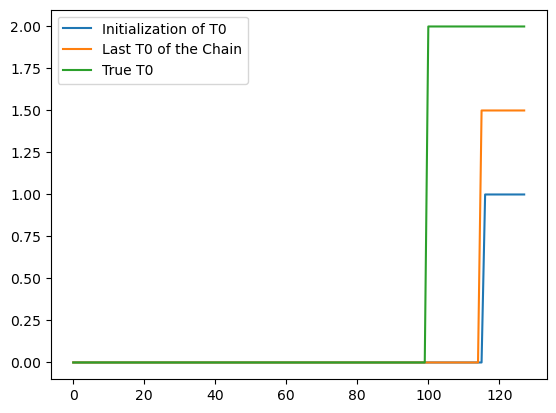

In [58]:
plt.plot(post.get_T0(),label='Initialization of T0')
plt.plot(1.5*np.array(chain[-1]),label='Last T0 of the Chain')
plt.plot(2*true_T0,label='True T0')
plt.legend()